# Neuro-Symbolic AI for Multivariate Time-Series Classification

Implementation based on this research paper: [Neuro-Symbolic Approaches for Context-Aware Human Activity
Recognition](https://arxiv.org/pdf/2306.05058.pdf)

Importing libraries

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
project_path = "/content/gdrive/MyDrive/ColabData"

import sys
sys.path.append('/content/gdrive/MyDrive/ColabData')

import pickle

Mounted at /content/gdrive


## Dataset loading

Loading a pre-processed version of the [DOMINO dataset](https://everywarelab.di.unimi.it/index.php/research/datasets/228-domino-a-dataset-for-context-aware-human-activity-recognition-using-mobile-devices).

This dataset includes inertial data collected from the smartphone and smartwatch of 25 different subjects and also information about their surrounding context (e.g., weather conditions, current speed, ...).

In particular, here the dataset has been pre-processed to obtain data windows of 4 seconds.

In [ ]:
with open(f"{project_path}/domino-segmented-w4-hz50.txt", "rb") as f:
  domino = pickle.load(f)

phone, watch, context = domino["phone"], domino["watch"], domino["enhanced_context"]
labels, users = domino["labels"], domino["users"]
del domino

<br>

Overall, we have 7656 data windows.

Smartphone and smartwatch windows are matrices with shape (200, 9): 200 raw measurements for each axis of a triaxial inertial sensor (accelerometer, gyroscope, and magnetometer).

Each window regarding context data contains one-hot encoded information about the user's context:
* if the user was indoor or outdoor
* the semantic place closest to the user (e.g., home, office, university, gym, ...)
* the user's current speed (i.e., null, low, medium, high)
* the surrounding weather conditions (e.g., sunny, rainy)
* if the user was following or not a public transportation route
* the user's current height variation (i.e., negative, null, positive)
* the environmental noise level (i.e., low, medium, high)

In [ ]:
print("Phone:", phone.shape)
print("Watch:", watch.shape)
print("Context:", context.shape)
print("Labels:", labels.shape)
print("Users:", users.shape)

Phone: (7656, 200, 9)
Watch: (7656, 200, 9)
Context: (7656, 34)
Labels: (7656,)
Users: (7656,)


In [ ]:
import numpy as np

context_mapper = {
    "Indoor": 0, "Outdoor": 1,
    "Home": 2, "Office": 3, "University": 4, "Mall": 5, "Station": 6, "Museum": 7, "Gym": 8, "Shop": 9, "Bar": 10, "Restaurant": 11, "Barbershop": 12, "Bank": 13, "Church": 14, "NullSemanticPlace": 15,
    "NullSpeed": 16, "LowSpeed": 17, "MediumSpeed": 18, "HighSpeed": 19,
    "Sunny": 20, "Rainy": 21, "Misty": 22, "Cloudy": 23, "Drizzly": 24, "Stormy": 25,
    "NotOnPublicTransportationRoute": 26, "OnPublicTransportationRoute": 27,
    "NegativeHeightVariation": 28, "NullHeightVariation": 29, "PositiveHeightVariation": 30,
    "LowAudioLevel": 31, "MediumAudioLevel": 32, "HighAudioLevel": 33
}

# mapping context data vectors to the original context information
inverse_context_mapper = {index:name for name,index in context_mapper.items()}

def derive_context(context_vector):
  '''
  This function derive a vector describing through strings the user's surrounding context based on a context data vector of the dataset
  '''
  context_vector = np.where(context_vector == 1)[0]   # returns the indices of the elements equal to 1
  context_vector = [inverse_context_mapper[index] for index in context_vector]  # gets the name of the active context information
  return context_vector

idx = 0
context_vector = context[idx]
print("Label:", labels[idx])
print("Subject ID:", users[idx])
print("Original context vector:", context_vector)
print("Was the subject indoors? (1 -> Yes, 0 -> No):", context_vector[context_mapper["Indoor"]])
print("Derive context:", derive_context(context_vector))

Label: SITTING
Subject ID: 1
Original context vector: [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0]
Was the subject indoors? (1 -> Yes, 0 -> No): 1
Derive context: ['Indoor', 'Barbershop', 'NullSpeed', 'Misty', 'NotOnPublicTransportationRoute', 'NullHeightVariation', 'LowAudioLevel']


<br>

Our goal will be multi-class classification. In particular, we want to distinguish 14 different activities.

In [ ]:
classes = list(np.unique(labels))
print("Activities: ", classes)

Activities:  ['BRUSHING_TEETH', 'CYCLING', 'ELEVATOR_DOWN', 'ELEVATOR_UP', 'LYING', 'MOVING_BY_CAR', 'RUNNING', 'SITTING', 'SITTING_ON_TRANSPORT', 'STAIRS_DOWN', 'STAIRS_UP', 'STANDING', 'STANDING_ON_TRANSPORT', 'WALKING']


<br>

In this notebook, we'll implement a Neuro-Symbolic AI approach for activity recognition. The idea is to infuse human knowledge into a deep learning classifier during its learning process to reduce the amount of labeled training data that it needs to reach satisfiable recognition rates.

Here, we load a file that contains, for each data window, information about the activities that are consistent with the user's surrounding context. This file have been created by building an ontology that define relationships between activities and context conditions in which they are consistent, according to commonsense knowledge about activity recognition. For instance, activities like *walking* and *running* are consistent only if the user's speed is positive.

Each consistency vector contains 14 elements, one for each activity class of the DOMINO dataset. In a vector, context-consistent activities are associated with the value 1, while context-inconsistent activities with the value 0.

In [ ]:
with open(f"{project_path}/consistencies.txt", "rb") as f:
  consistencies = pickle.load(f)

print(consistencies.shape)

(7656, 14)


In [ ]:
print("Example of consistency vector:", consistencies[0])

Example of consistency vector: [0 0 0 0 1 0 0 1 0 0 0 1 0 0]


In the example below, context-consistent activities are *lying*, *sitting*, and *standing*.

In [ ]:
idx = 963
print("Ground truth:", labels[idx])
print("Context window:", derive_context(context[idx]))
print("Consistency vector:", consistencies[idx])
print("Activity classes:", classes)

Ground truth: STANDING
Context window: ['Indoor', 'Mall', 'NullSpeed', 'Sunny', 'NotOnPublicTransportationRoute', 'NullHeightVariation', 'HighAudioLevel']
Consistency vector: [0 0 0 0 1 0 0 1 0 0 0 1 0 0]
Activity classes: ['BRUSHING_TEETH', 'CYCLING', 'ELEVATOR_DOWN', 'ELEVATOR_UP', 'LYING', 'MOVING_BY_CAR', 'RUNNING', 'SITTING', 'SITTING_ON_TRANSPORT', 'STAIRS_DOWN', 'STAIRS_UP', 'STANDING', 'STANDING_ON_TRANSPORT', 'WALKING']


<br>

Let's one-hot encode the labels in order to train our deep learning model.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
ohe_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()

print(f"Original list of labels: {classes}")

print(f'Example of original label: {labels[3000]}')
print(f"...and the corresponding one-hot encoded version: {ohe_labels[3000]}")

Original list of labels: ['BRUSHING_TEETH', 'CYCLING', 'ELEVATOR_DOWN', 'ELEVATOR_UP', 'LYING', 'MOVING_BY_CAR', 'RUNNING', 'SITTING', 'SITTING_ON_TRANSPORT', 'STAIRS_DOWN', 'STAIRS_UP', 'STANDING', 'STANDING_ON_TRANSPORT', 'WALKING']
Example of original label: STANDING
...and the corresponding one-hot encoded version: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


<br>

Here, we build an utility function that allows reducing the amount of available training data to simulate data scarcity scenarios that are prohibitive without Neuro-Symbolic AI.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

def reduce_training_set(Y_samples, sampling_ratio, classes, sampler_random_state=0, verbosity=0):
  # count the number of samples for each class
  counter = {el:0 for el in classes}
  for el in Y_samples: counter[el] += 1
  if verbosity == 1: print(f"Support before under-sampling: total = {len(Y_samples)}, {counter}")

  # define the UnderSampler and how it has to undersample our data
  sampling_dict = {cls:int(val*sampling_ratio) for cls, val in counter.items()}
  underSampler = RandomUnderSampler(sampling_strategy=sampling_dict, random_state=sampler_random_state)

  indices = np.array(list(range(0, len(Y_samples))))  # list that contains the indices of our data from 0 to the number of the input data samples
  indices = indices.reshape(-1,1)  # RandomUnderSampler expects an input with shape (number_of_samples, number_of_features)
  indices_resampled, Y_resampled = underSampler.fit_resample(indices.reshape(-1,1), Y_samples)

  indices_resampled = indices_resampled.reshape(1,-1)[0]  # here, we obtain again a single list with the indices of the elements that we have to consider to work on undersampled data

  if verbosity == 1:
    counter = {el:0 for el in classes}
    for el in Y_resampled: counter[el] += 1
    print(f"Support after under-sampling: total = {len(Y_resampled)}, {counter}")

  # return the indices that we have to consider to work on undersampled data
  return indices_resampled

In [ ]:
indices_resampled = reduce_training_set(labels, sampling_ratio=0.10, classes=classes, verbosity=1)

Support before under-sampling: total = 7656, {'BRUSHING_TEETH': 163, 'CYCLING': 323, 'ELEVATOR_DOWN': 171, 'ELEVATOR_UP': 110, 'LYING': 387, 'MOVING_BY_CAR': 188, 'RUNNING': 334, 'SITTING': 1764, 'SITTING_ON_TRANSPORT': 213, 'STAIRS_DOWN': 266, 'STAIRS_UP': 187, 'STANDING': 1875, 'STANDING_ON_TRANSPORT': 297, 'WALKING': 1378}
Support after under-sampling: total = 759, {'BRUSHING_TEETH': 16, 'CYCLING': 32, 'ELEVATOR_DOWN': 17, 'ELEVATOR_UP': 11, 'LYING': 38, 'MOVING_BY_CAR': 18, 'RUNNING': 33, 'SITTING': 176, 'SITTING_ON_TRANSPORT': 21, 'STAIRS_DOWN': 26, 'STAIRS_UP': 18, 'STANDING': 187, 'STANDING_ON_TRANSPORT': 29, 'WALKING': 137}


<br>

Let's also create an utility function to plot our confusion matrices.

In [ ]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, cmap=plt.cm.Blues, figsize=(22,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=+++90, fontsize=11)
    plt.yticks(tick_marks, classes, fontsize=11)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black"
               )

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.tick_params(axis="both", which="both", bottom=False, left=False)
    plt.grid(False)
    plt.box(False) #remove box
    return plt

<br>

From now on, we'll build and train a fully-supervised baseline model that will be compared to Neuro-Symbolic AI approach that infuse human knowledge (context-consistencies information) into the model during training through a custom loss function.

## Baseline

Let's start building a baseline model that just receives through different input flows inertial data (from both smartphones and smartwatches) and context data. We will compare this baseline model with our Neuro-Symbolic AI solutions!

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate, Conv1D, MaxPooling1D, GlobalMaxPool1D
from tensorflow.keras import backend as K

def baseline(num_classes=len(classes)):
  phone_input = Input((200, 9), name="phone_input")
  x1 = Conv1D(filters=32, kernel_size=24, activation='relu', name="conv_phone1")(phone_input)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool_phone1")(x1)
  x1 = Conv1D(filters=64, kernel_size=16, activation='relu', name="conv_phone2")(x1)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool_phone2")(x1)
  x1 = Conv1D(filters=96, kernel_size=8, activation='relu', name="conv_phone3")(x1)
  x1 = GlobalMaxPool1D(name='global_max_pooling1d_phone')(x1)
  x1 = Dense(128, activation='relu', name="dense_phone")(x1)

  watch_input = Input((200, 9), name="watch_input")
  x2 = Conv1D(filters=32, kernel_size=24, activation='relu', name="conv_watch1")(watch_input)
  x2 = MaxPooling1D(4, 1, padding="valid", name="max_pool_watch1")(x2)
  x2 = Conv1D(filters=64, kernel_size=16, activation='relu', name="conv_watch2")(x2)
  x2 = MaxPooling1D(4, 1, padding="valid", name="max_pool_watch2")(x2)
  x2 = Conv1D(filters=96, kernel_size=8, activation='relu', name="conv_watch3")(x2)
  x2 = GlobalMaxPool1D(name='global_max_pooling1d_watch')(x2)
  x2 = Dense(128, activation='relu', name="dense_watch")(x2)

  context_input = Input((34,), name="context_input")
  x3 = Dense(8, activation='relu', name="dense_context")(context_input)

  concat = Concatenate(name="concatenate")([x1, x2, x3])
  concat = Dropout(0.1)(concat)
  concat = Dense(256, activation='relu')(concat)
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(concat)

  model = Model(inputs=[phone_input, watch_input, context_input], outputs=classification_out)

  return model

In [ ]:
model = baseline()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phone_input (InputLayer)       [(None, 200, 9)]     0           []                               
                                                                                                  
 watch_input (InputLayer)       [(None, 200, 9)]     0           []                               
                                                                                                  
 conv_phone1 (Conv1D)           (None, 177, 32)      6944        ['phone_input[0][0]']            
                                                                                                  
 conv_watch1 (Conv1D)           (None, 177, 32)      6944        ['watch_input[0][0]']            
                                                                                              

<br>

Let's train the baseline by reducing the available training data sample to 10%.


Resampling...
Support before under-sampling: total = 5358, {'BRUSHING_TEETH': 106, 'CYCLING': 229, 'ELEVATOR_DOWN': 121, 'ELEVATOR_UP': 78, 'LYING': 278, 'MOVING_BY_CAR': 124, 'RUNNING': 242, 'SITTING': 1259, 'SITTING_ON_TRANSPORT': 156, 'STAIRS_DOWN': 187, 'STAIRS_UP': 128, 'STANDING': 1289, 'STANDING_ON_TRANSPORT': 197, 'WALKING': 964}
Support after under-sampling: total = 527, {'BRUSHING_TEETH': 10, 'CYCLING': 22, 'ELEVATOR_DOWN': 12, 'ELEVATOR_UP': 7, 'LYING': 27, 'MOVING_BY_CAR': 12, 'RUNNING': 24, 'SITTING': 125, 'SITTING_ON_TRANSPORT': 15, 'STAIRS_DOWN': 18, 'STAIRS_UP': 12, 'STANDING': 128, 'STANDING_ON_TRANSPORT': 19, 'WALKING': 96}
Training set rate: 0.07,  Validation set rate: 0.1,  Test set rate: 0.2

Creating the model...

Training...
Epoch 1/100
5/5 [==============================] - 6s 742ms/step - loss: 2.3486 - accuracy: 0.3435 - val_loss: 2.0686 - val_accuracy: 0.4295
Epoch 2/100
5/5 [==============================] - 4s 611ms/step - loss: 1.7405 - accuracy: 0.5787 -

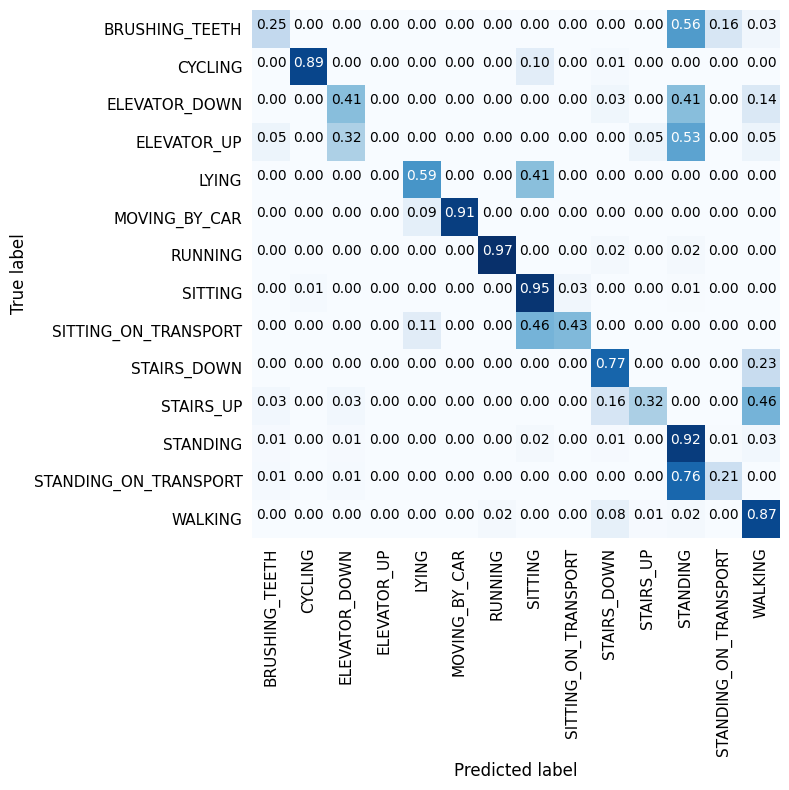

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, LeaveOneGroupOut, ShuffleSplit, train_test_split, GroupKFold

# early stopping: if for 5 consecutive epochs the loss on the validation set does not improve, we stop the training process and restore the weights of the best model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
split = ss.split(ohe_labels)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 100
batch_size = 128
training_set_percentage = 0.10

for train, test in split:
  ohe_labels_train, ohe_labels_test = ohe_labels[train], ohe_labels[test]
  labels_train, labels_test = labels[train], labels[test]
  phone_train, phone_test = phone[train], phone[test]
  watch_train, watch_test = watch[train], watch[test]
  context_train, context_test = context[train], context[test]

  # by taking the 12.5% of the training set for the validation set, we obtain a 10% of validation data over the whole dataset
  phone_train, phone_val, watch_train, watch_val, context_train, context_val, labels_train, labels_val, ohe_labels_train, ohe_labels_val = train_test_split(phone_train, watch_train, context_train, labels_train, ohe_labels_train, test_size=0.125, random_state=0)

  # we resample training data to work only with 1% of them!
  print("\nResampling...")
  indices_resampled = reduce_training_set(labels_train, sampling_ratio=training_set_percentage, classes=classes, verbosity=1)
  ohe_labels_train, labels_train = ohe_labels_train[indices_resampled], labels_train[indices_resampled]
  phone_train, watch_train, context_train = phone_train[indices_resampled], watch_train[indices_resampled], context_train[indices_resampled]



  print(f"Training set rate: {round(len(phone_train)/len(phone), 2)},\
  Validation set rate: {round(len(phone_val)/len(phone), 2)},\
  Test set rate: {round(len(phone_test)/len(phone), 2)}")


  print("\nCreating the model...")
  model = baseline()
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


  print("\nTraining...")
  history = model.fit(x=[phone_train, watch_train, context_train],
                    y=ohe_labels_train,
                    batch_size = batch_size,
                    epochs = n_epochs,
                    validation_data = ([phone_val, watch_val, context_val], ohe_labels_val),
                    callbacks=[early_stopping])


  print("\nPredicting...")
  y_preds = model.predict([phone_test, watch_test, context_test])

  y_preds = np.argmax(y_preds, axis=1)
  y_targets = np.argmax(ohe_labels_test, axis=1)


  print("\nClassification Report:")
  print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


  print("\nConfusion Matrix:")
  s_preds, s_targets = [], []
  for el in y_preds: s_preds.append(classes[el])
  for el in y_targets: s_targets.append(classes[el])

  cm += confusion_matrix(s_targets, s_preds, labels=classes)
  cm = cm.astype(np.int32)

  plot_confusion_matrix(cm, classes)

## Knowledge Infusion through Semantic Loss (Neuro-Symbolic AI)

Here we build our Neuro-Symbolic AI model. It is a deep neural network that combines a standard loss function with a custom loss function that penalizes predictions that are not context-consistent according to human commonsense knowledge!

In [ ]:
def semantic_loss(num_classes=len(classes)):
  phone_input = Input((200, 9), name="phone_input")
  x1 = Conv1D(filters=32, kernel_size=24, activation='relu', name="conv_phone1")(phone_input)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool_phone1")(x1)
  x1 = Conv1D(filters=64, kernel_size=16, activation='relu', name="conv_phone2")(x1)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool_phone2")(x1)
  x1 = Conv1D(filters=96, kernel_size=8, activation='relu', name="conv_phone3")(x1)
  x1 = GlobalMaxPool1D(name='global_max_pooling1d_phone')(x1)
  x1 = Dense(128, activation='relu', name="dense_phone")(x1)

  watch_input = Input((200, 9), name="watch_input")
  x2 = Conv1D(filters=32, kernel_size=24, activation='relu', name="conv_watch1")(watch_input)
  x2 = MaxPooling1D(4, 1, padding="valid", name="max_pool_watch1")(x2)
  x2 = Conv1D(filters=64, kernel_size=16, activation='relu', name="conv_watch2")(x2)
  x2 = MaxPooling1D(4, 1, padding="valid", name="max_pool_watch2")(x2)
  x2 = Conv1D(filters=96, kernel_size=8, activation='relu', name="conv_watch3")(x2)
  x2 = GlobalMaxPool1D(name='global_max_pooling1d_watch')(x2)
  x2 = Dense(128, activation='relu', name="dense_watch")(x2)

  context_input = Input((34,), name="context_input")
  x3 = Dense(8, activation='relu', name="dense_context")(context_input)

  concat = Concatenate(name="concatenate")([x1, x2, x3])
  concat = Dropout(0.1)(concat)
  concat = Dense(256, activation='relu')(concat)
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(concat)

  # consistencies and classification_out will be used by the semantic loss to check if the prediction of the classifier is consistent according to the ontology
  consistencies = Input((num_classes), name="consistencies")
  semantic_out = Concatenate(name="semantic_out")([consistencies, classification_out])

  model = Model(inputs=[phone_input, watch_input, context_input, consistencies], outputs=[semantic_out, classification_out])

  return model

In [ ]:
model = semantic_loss()
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phone_input (InputLayer)       [(None, 200, 9)]     0           []                               
                                                                                                  
 watch_input (InputLayer)       [(None, 200, 9)]     0           []                               
                                                                                                  
 conv_phone1 (Conv1D)           (None, 177, 32)      6944        ['phone_input[0][0]']            
                                                                                                  
 conv_watch1 (Conv1D)           (None, 177, 32)      6944        ['watch_input[0][0]']            
                                                                                            

<br>

Here we define our custom loss function. The idea is that the model will learn to assign non-zero probabilities only to context-consistent activities through this formula:

$$ 1 - {\sum p(i) * c(i)}$$

Where p(i) is the probability value for the i-th activity class emitted by the deep learning model and c(i) is the consistency value (i.e., 1 if consistent, 0 otherwise) for the same activity class.

In [ ]:
# the implementation of our custom loss function
def semantic_loss_impl(x_inp, y_pred):
  consistent_acts_indices = tf.where(x_inp != 0)    # get the indices of context-consistent activities
  consistent_acts_indices = tf.reshape(consistent_acts_indices, [len(consistent_acts_indices)])
  consistent_acts_indices = tf.cast(consistent_acts_indices, dtype=float)

  def get_single_value(index):
    index = tf.cast(index, dtype=tf.int32)
    y_val = y_pred[index]                   # get the probability of the current activity class
    return tf.cast(y_val, dtype=float)      # and return it (because we call this function only for context-consistent activity classes)

  values = tf.map_fn(get_single_value, consistent_acts_indices) # a vector that contains the probability values associated with context-consistent activities
  return 1 - tf.reduce_sum(values)   # apply our custom loss formula


# semantic_weight: a parameter we can use to specify how much the semantic loss should be important during training
def custom_loss_with_params(semantic_weight):
  def loss(y_true, network_out):   # y_true -> the labels for this batch, network_out -> the predictions for this batch (in our case, it will be semantic_out)
    # create an array in which we will put the semantic loss value for each sample in the current training batch
    # the dimension is len(y_true) instead of batch_size because in the last step of a training epoch the array cold be not completely full (i.e., it does not reach the full batch size)
    semantic_loss = tf.zeros([len(y_true)])

    # if the semantic_weight is 0, we return a semantic loss equal to 0 for each sample in the batch -> it will not influence the training process
    if semantic_weight == 0.0: return semantic_loss

    def compute_single_semantic_loss(single_network_out):
      # remember that the network output in our case is semantic_out: the first 14 elements consist of the consistencies vector, while the last 14 elements consist of the prediction
      single_x_consistencies = single_network_out[:len(classes)]
      single_y_pred = single_network_out[-len(classes):]
      return semantic_loss_impl(single_x_consistencies, single_y_pred)

    # for each prediction that we have in network_out, we compute the semantic loss
    semantic_loss = tf.map_fn(compute_single_semantic_loss, network_out)

    return semantic_loss
  return loss

<br>

Let's train our Neuro-Symbolic AI model. Also in this case we consider a data scarcity scenario where only 10% of training data are available.


Resampling...
Support before under-sampling: total = 5358, {'BRUSHING_TEETH': 106, 'CYCLING': 229, 'ELEVATOR_DOWN': 121, 'ELEVATOR_UP': 78, 'LYING': 278, 'MOVING_BY_CAR': 124, 'RUNNING': 242, 'SITTING': 1259, 'SITTING_ON_TRANSPORT': 156, 'STAIRS_DOWN': 187, 'STAIRS_UP': 128, 'STANDING': 1289, 'STANDING_ON_TRANSPORT': 197, 'WALKING': 964}
Support after under-sampling: total = 527, {'BRUSHING_TEETH': 10, 'CYCLING': 22, 'ELEVATOR_DOWN': 12, 'ELEVATOR_UP': 7, 'LYING': 27, 'MOVING_BY_CAR': 12, 'RUNNING': 24, 'SITTING': 125, 'SITTING_ON_TRANSPORT': 15, 'STAIRS_DOWN': 18, 'STAIRS_UP': 12, 'STANDING': 128, 'STANDING_ON_TRANSPORT': 19, 'WALKING': 96}
Training set rate: 0.07,  Validation set rate: 0.1,  Test set rate: 0.2

Creating the model...

Training...
Epoch 1/100
5/5 [==============================] - 8s 898ms/step - loss: 3.1203 - semantic_out_loss: 0.6835 - classification_out_loss: 2.4368 - semantic_out_accuracy: 0.1879 - classification_out_accuracy: 0.1822 - val_loss: 2.7135 - val_sema

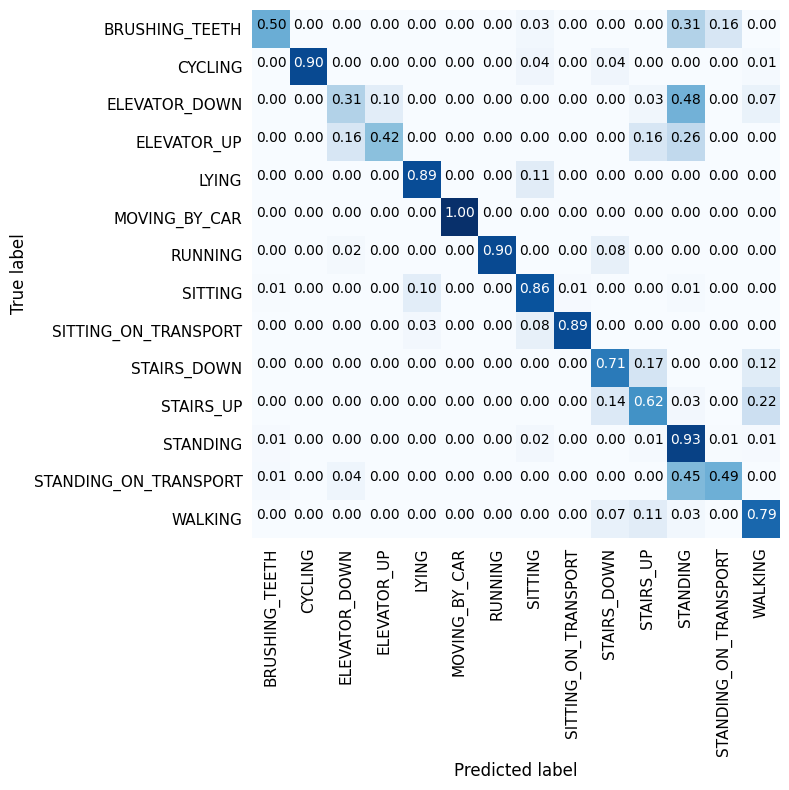

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold, LeaveOneGroupOut, ShuffleSplit, train_test_split, GroupKFold

# early stopping: if for 5 consecutive epochs the loss on the validation set does not improve, we stop the training process and restore the weights of the best model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
split = ss.split(ohe_labels)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 100
batch_size = 128
training_set_percentage = 0.10

semantic_weight = 1.0
classification_weight = 1.0

for train, test in split:
  ohe_labels_train, ohe_labels_test = ohe_labels[train], ohe_labels[test]
  labels_train, labels_test = labels[train], labels[test]
  phone_train, phone_test = phone[train], phone[test]
  watch_train, watch_test = watch[train], watch[test]
  context_train, context_test = context[train], context[test]
  consistencies_train, consistencies_test = consistencies[train], consistencies[test]

  # by taking the 12.5% of the training set for the validation set, we obtain a 10% of validation data over the whole dataset
  phone_train, phone_val, watch_train, watch_val, context_train, context_val, consistencies_train, consistencies_val, labels_train, labels_val, ohe_labels_train, ohe_labels_val = train_test_split(phone_train, watch_train, context_train, consistencies_train, labels_train, ohe_labels_train, test_size=0.125, random_state=0)

  # we resample training data to work only with 1% of them!
  print("\nResampling...")
  indices_resampled = reduce_training_set(labels_train, sampling_ratio=training_set_percentage, classes=classes, verbosity=1)
  ohe_labels_train, labels_train = ohe_labels_train[indices_resampled], labels_train[indices_resampled]
  phone_train, watch_train, context_train = phone_train[indices_resampled], watch_train[indices_resampled], context_train[indices_resampled]
  consistencies_train = consistencies_train[indices_resampled]


  print(f"Training set rate: {round(len(phone_train)/len(phone), 2)},\
  Validation set rate: {round(len(phone_val)/len(phone), 2)},\
  Test set rate: {round(len(phone_test)/len(phone), 2)}")


  print("\nCreating the model...")
  model = semantic_loss()
  model.compile(optimizer = 'adam', metrics=['accuracy'],
                    loss = {"semantic_out": custom_loss_with_params(semantic_weight), "classification_out": 'categorical_crossentropy'},
                    loss_weights = {"semantic_out": semantic_weight, "classification_out": classification_weight})


  print("\nTraining...")
  history = model.fit(x=[phone_train, watch_train, context_train, consistencies_train],
                    y=ohe_labels_train,
                    batch_size = batch_size,
                    epochs = n_epochs,
                    validation_data = ([phone_val, watch_val, context_val, consistencies_val], ohe_labels_val),
                    callbacks=[early_stopping])


  print("\nPredicting...")
  # Reasoning is used only during training for the semantic loss. Hence, during test we can provide a fake consistencies vector since it will not be considered
  fake_x_consistencies_test = np.zeros((len(test), len(classes)))

  y_preds = model.predict([phone_test, watch_test, context_test, fake_x_consistencies_test])
  y_preds = y_preds[1]    # remember that we have two outputs (semantic_out and classification_out), here we get classification_out

  y_preds = np.argmax(y_preds, axis=1)
  y_targets = np.argmax(ohe_labels_test, axis=1)


  print("\nClassification Report:")
  print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


  print("\nConfusion Matrix:")
  s_preds, s_targets = [], []
  for el in y_preds: s_preds.append(classes[el])
  for el in y_targets: s_targets.append(classes[el])

  cm += confusion_matrix(s_targets, s_preds, labels=classes)
  cm = cm.astype(np.int32)

  plot_confusion_matrix(cm, classes)

<br>

Here, we sum up the results of the two models.

|                       | Baseline |   | Neuro-Symbolic AI |
|-----------------------|:--------:|---|:-----------------:|
| Accuracy              |  0.8048  |   |     **0.8251**    |
| Macro avg F1-score    |  0.6283  |   |     **0.7339**    |
| Weighted avg F1-score |  0.7843  |   |     **0.8275**    |

<br>

We can see how our simple custom loss function is able to infuse human knowledge into the model, increasing the recognition rates when there are no enough training data to effectively learn such a knowledge in a data-driven way.